#**ABOUT THE PROJECT**

CDC Diabetes health indicators dataset is used is used for this project to illustrate how I go about model selection. I first do predictions with a couple of untuned models, using the train test original data. I then balance the dataset when need, do parameter tuning, apply best thresholds and use PCA (using different variation retantion )

The dataset is available at https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators

**Problem Statement**: Predict whether an individual is diabetic based on health indicators such as BMI, smoking, physical activity, etc.

**Target Variable**: Diabetes_binary (1 = diabetic, 0 = not diabetic)

**Goal**: Build a classification model that, ensuring that both classes (diabetic and non-diabetic) are detected well, with priority given to detecting all diabetic cases to target these for proper diagnosis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
)


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA


##**Load the data**

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# metadata
print(cdc_diabetes_health_indicators.metadata)

# variable information
print(cdc_diabetes_health_indicators.variables)

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [4]:
# Combine features and targets into one DataFrame
df_cdc_diabetes = pd.concat([X, y], axis=1)

# Save to CSV
df_cdc_diabetes.to_csv('cdc_diabetes_health_indicators', index=False)  # index=False prevents writing row numbers

In [5]:
# Read the CSV file into a DataFrame
df_cdc_diabetes = pd.read_csv('cdc_diabetes_health_indicators')

In [6]:
df_cdc_diabetes.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0


##**Data exploration and Preprocessing**

In [7]:
df_cdc_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth              253680 non-null  int64
 15  PhysHlth              253680 non-n

In [8]:
df_cdc_diabetes.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'Diabetes_binary'],
      dtype='object')

In [9]:
# target class balance
df_cdc_diabetes['Diabetes_binary'].value_counts()               # raw counts
df_cdc_diabetes['Diabetes_binary'].value_counts(normalize=True) # proportions

,proportion
Diabetes_binary,
0,0.860667
1,0.139333


###**EDA**

Data distribution, outliers, and correlation - visualisation

In [10]:
#Group columns as Numerical vs Binary
numerical_cols = ['BMI','GenHlth','MentHlth','PhysHlth','Age', 'Education', 'Income']     # numerical values columns
binary_cols = df_cdc_diabetes.columns.difference(numerical_cols + ['Diabetes_binary']) # Binary columns


Distribution for numerical columns:

Column: BMI
count    253680.000000
mean         28.382364
std           6.608694
min          12.000000
25%          24.000000
50%          27.000000
75%          31.000000
max          98.000000
Name: BMI, dtype: float64


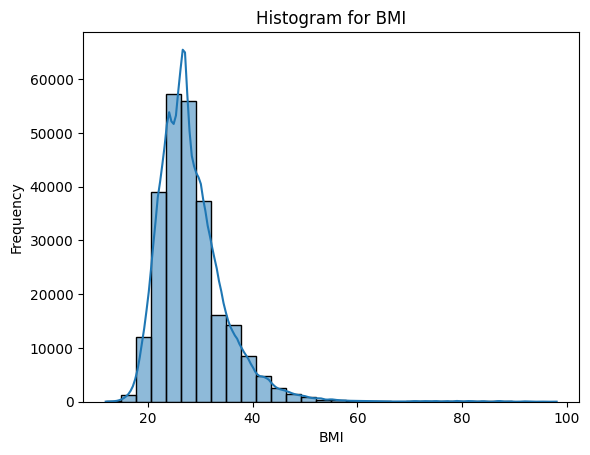


Column: GenHlth
count    253680.000000
mean          2.511392
std           1.068477
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           5.000000
Name: GenHlth, dtype: float64


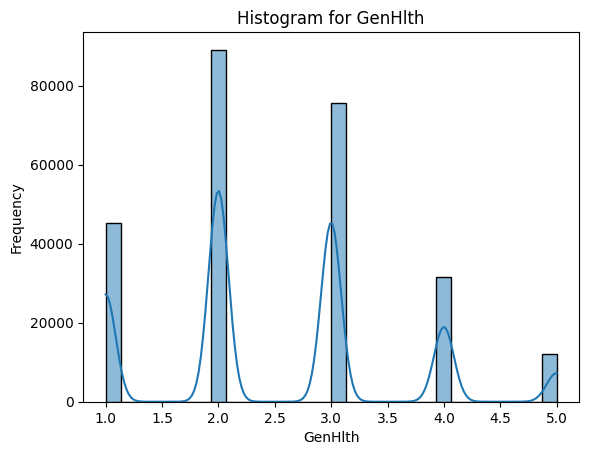


Column: MentHlth
count    253680.000000
mean          3.184772
std           7.412847
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          30.000000
Name: MentHlth, dtype: float64


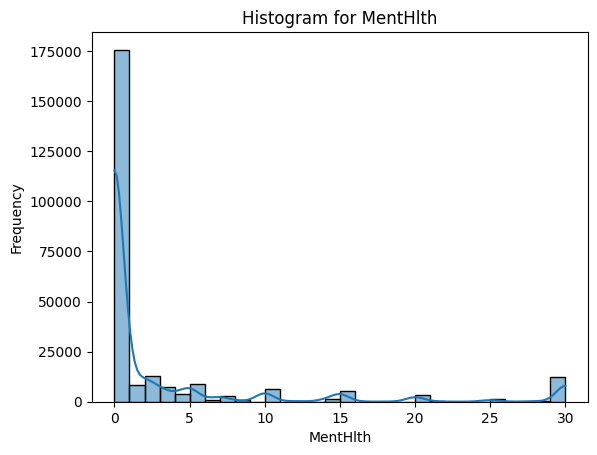


Column: PhysHlth
count    253680.000000
mean          4.242081
std           8.717951
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          30.000000
Name: PhysHlth, dtype: float64


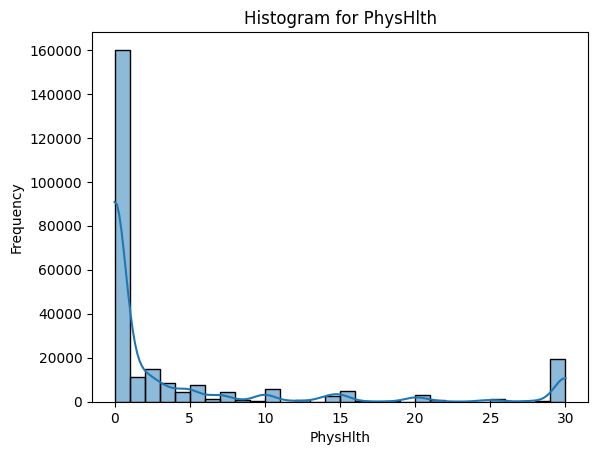


Column: Age
count    253680.000000
mean          8.032119
std           3.054220
min           1.000000
25%           6.000000
50%           8.000000
75%          10.000000
max          13.000000
Name: Age, dtype: float64


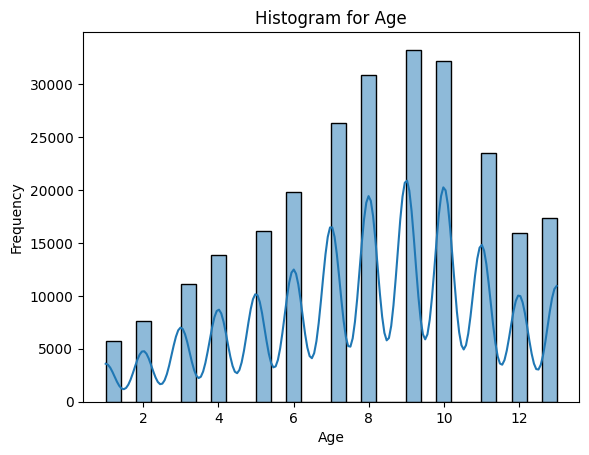


Column: Education
count    253680.000000
mean          5.050434
std           0.985774
min           1.000000
25%           4.000000
50%           5.000000
75%           6.000000
max           6.000000
Name: Education, dtype: float64


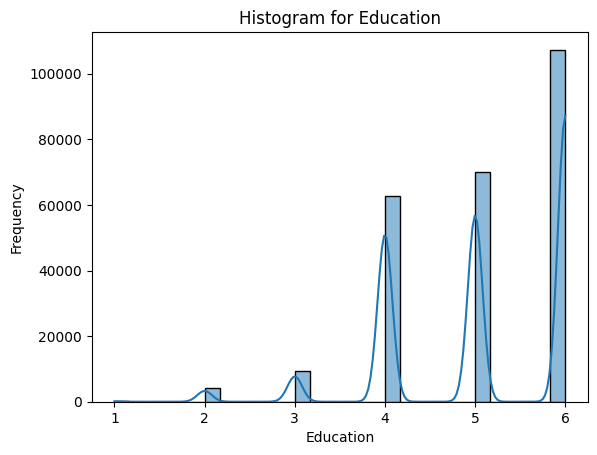


Column: Income
count    253680.000000
mean          6.053875
std           2.071148
min           1.000000
25%           5.000000
50%           7.000000
75%           8.000000
max           8.000000
Name: Income, dtype: float64


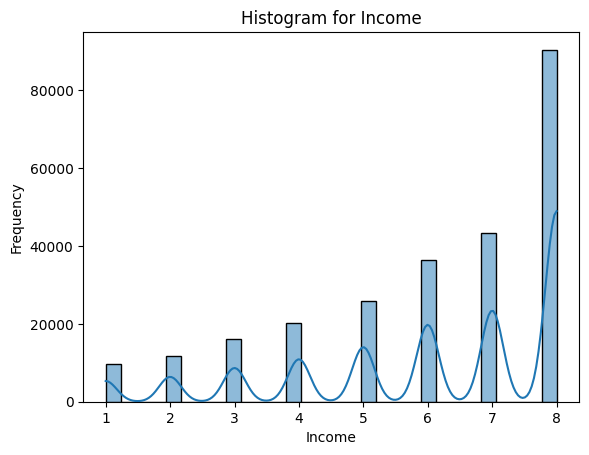

In [11]:
#Histograms for all numeric variables

print("\nDistribution for numerical columns:")
for col in numerical_cols:
    print(f"\nColumn: {col}")
    print(df_cdc_diabetes[col].describe())
    sns.histplot(df_cdc_diabetes[col], bins=30, kde=True)
    plt.title(f"Histogram for {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


Column: AnyHealthcare
AnyHealthcare
1    241263
0     12417
Name: count, dtype: int64


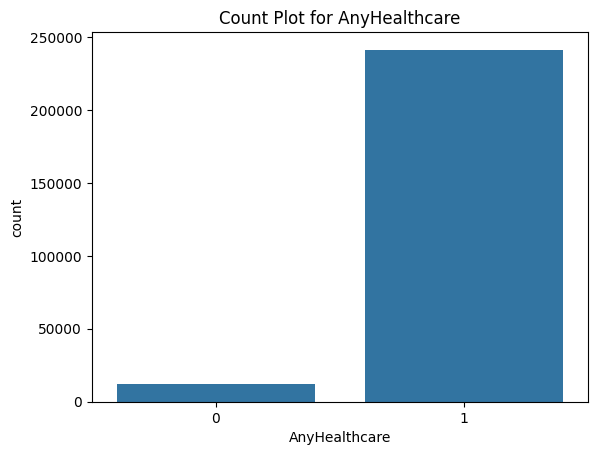


Column: CholCheck
CholCheck
1    244210
0      9470
Name: count, dtype: int64


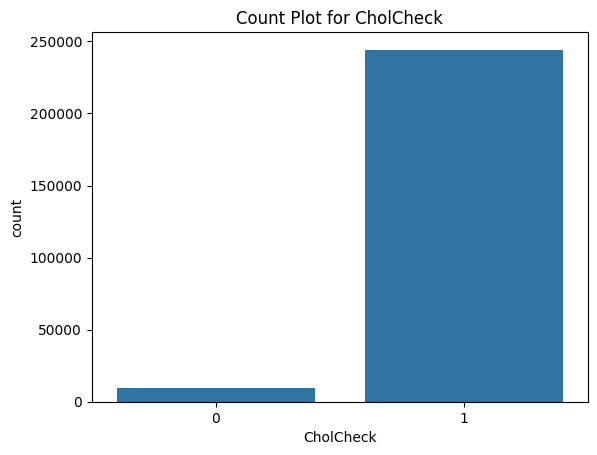


Column: DiffWalk
DiffWalk
0    211005
1     42675
Name: count, dtype: int64


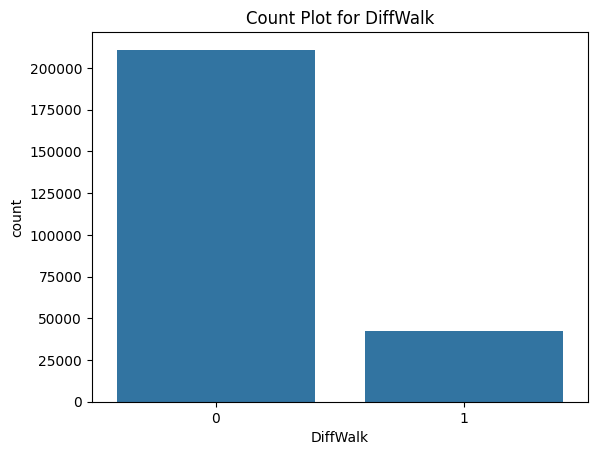


Column: Fruits
Fruits
1    160898
0     92782
Name: count, dtype: int64


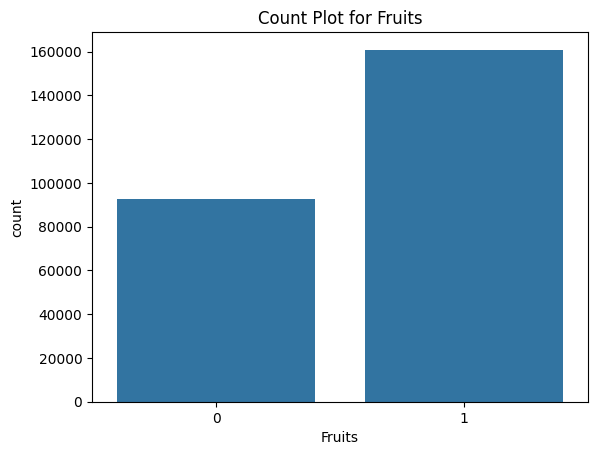


Column: HeartDiseaseorAttack
HeartDiseaseorAttack
0    229787
1     23893
Name: count, dtype: int64


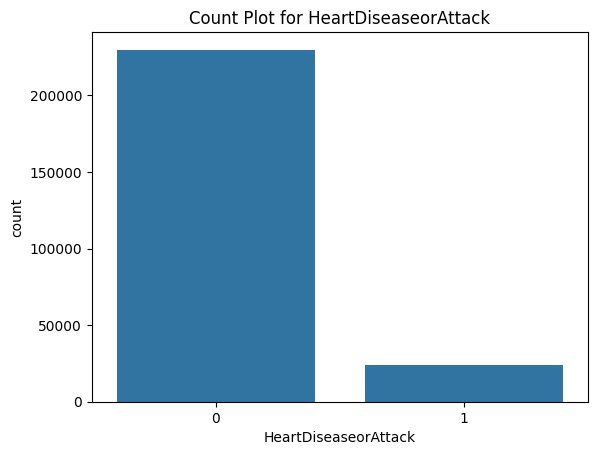


Column: HighBP
HighBP
0    144851
1    108829
Name: count, dtype: int64


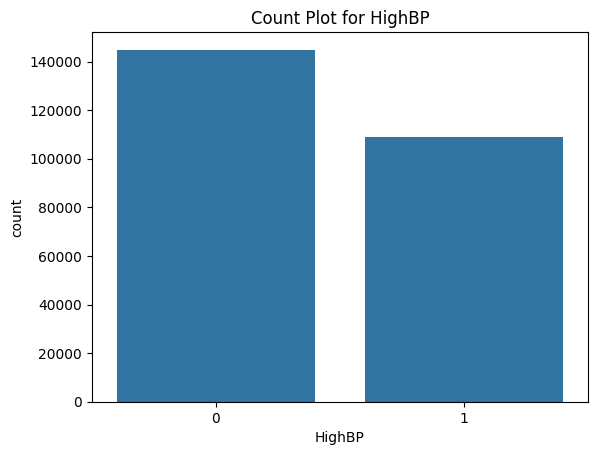


Column: HighChol
HighChol
0    146089
1    107591
Name: count, dtype: int64


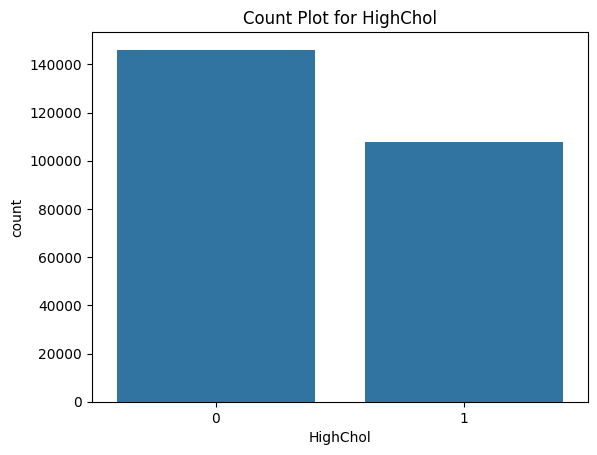


Column: HvyAlcoholConsump
HvyAlcoholConsump
0    239424
1     14256
Name: count, dtype: int64


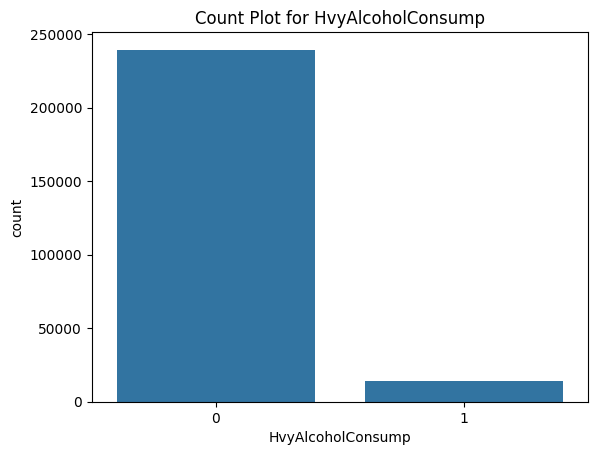


Column: NoDocbcCost
NoDocbcCost
0    232326
1     21354
Name: count, dtype: int64


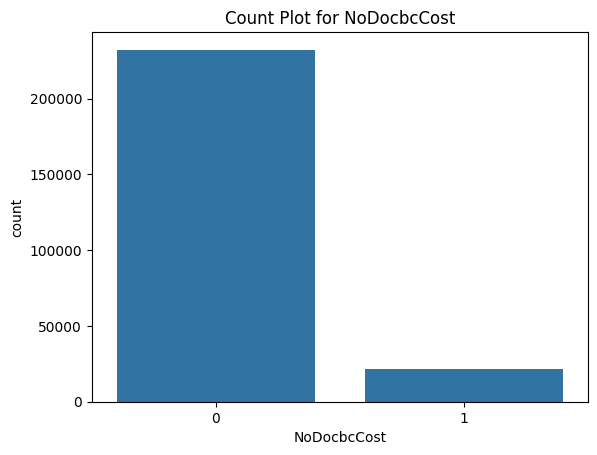


Column: PhysActivity
PhysActivity
1    191920
0     61760
Name: count, dtype: int64


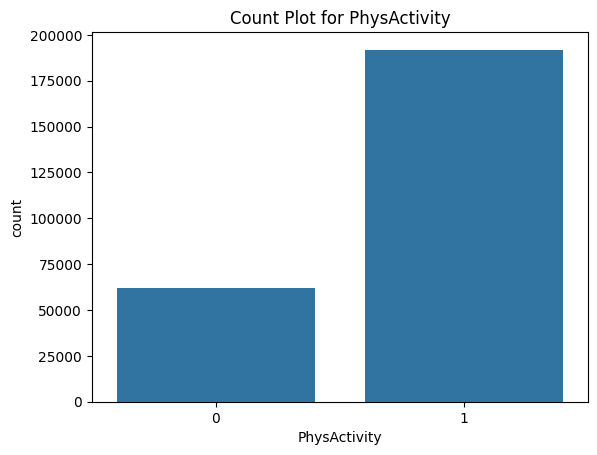


Column: Sex
Sex
0    141974
1    111706
Name: count, dtype: int64


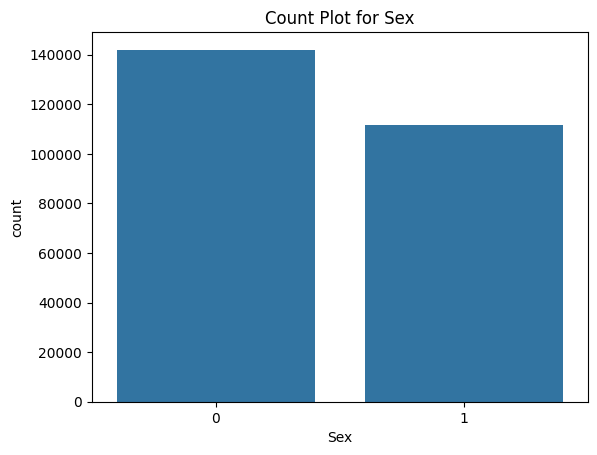


Column: Smoker
Smoker
0    141257
1    112423
Name: count, dtype: int64


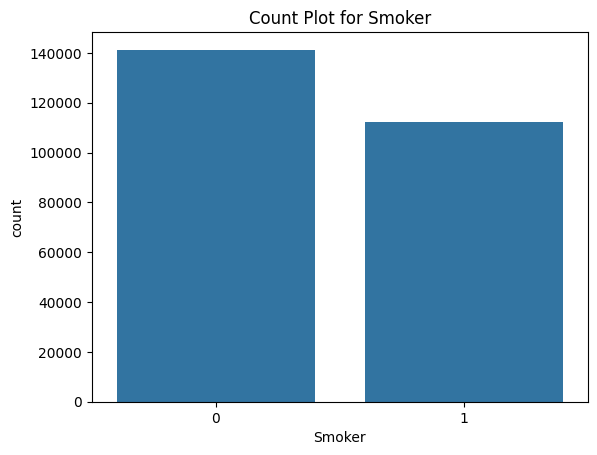


Column: Stroke
Stroke
0    243388
1     10292
Name: count, dtype: int64


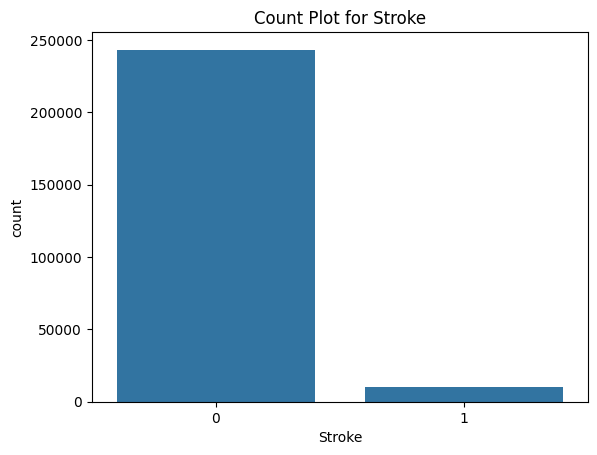


Column: Veggies
Veggies
1    205841
0     47839
Name: count, dtype: int64


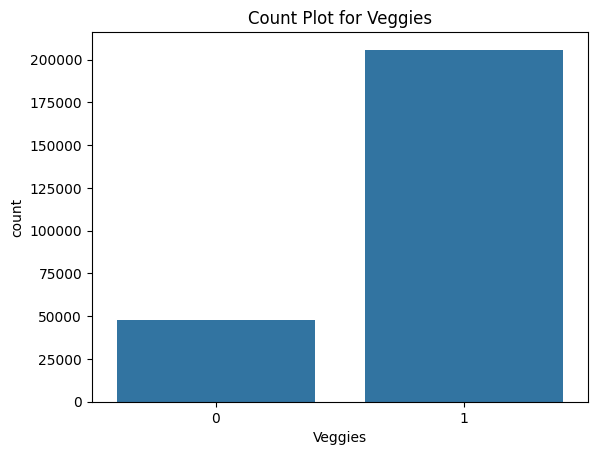

In [12]:
# Value distribution for binary/categorical columns

for col in binary_cols:
    print(f"\nColumn: {col}")
    print(df_cdc_diabetes[col].value_counts(dropna=False))
    sns.countplot(x=col, data=df_cdc_diabetes)
    plt.title(f"Count Plot for {col}")
    plt.show()


Box plot for: BMI


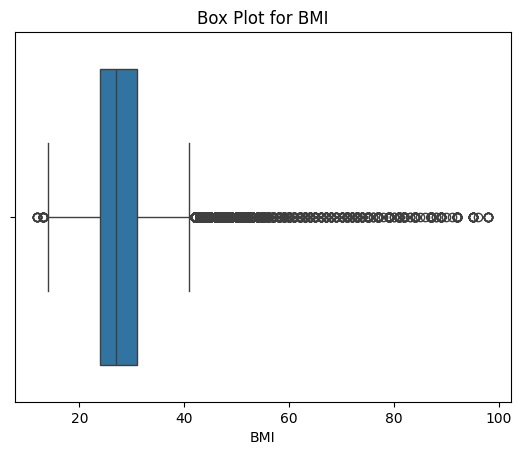


Box plot for: GenHlth


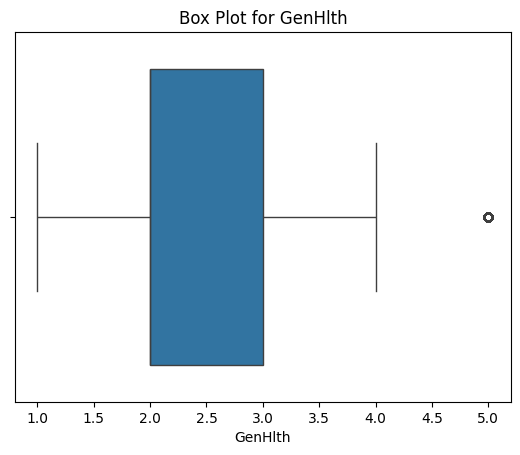


Box plot for: MentHlth


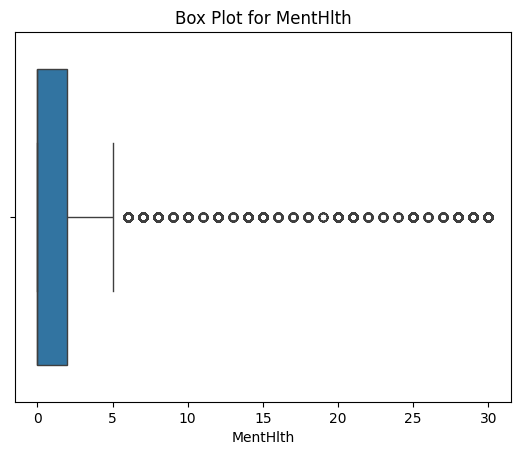


Box plot for: PhysHlth


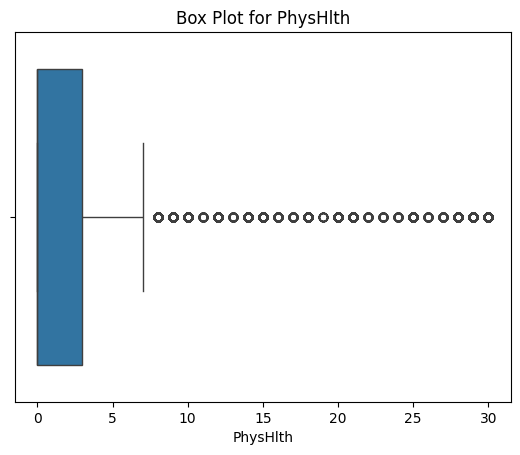


Box plot for: Age


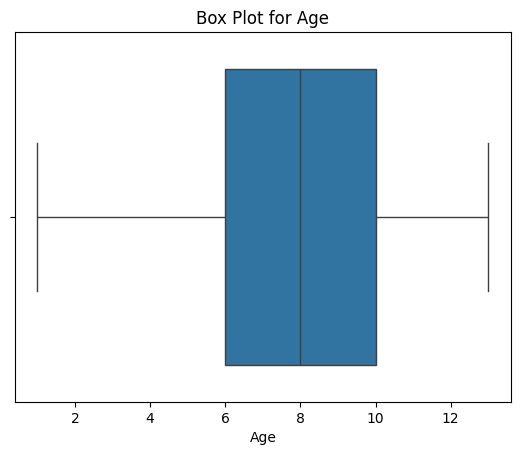


Box plot for: Education


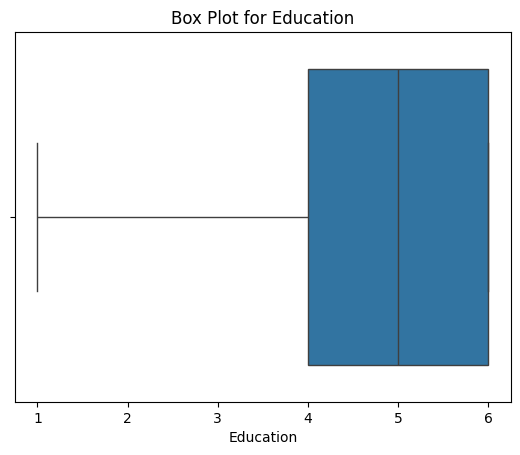


Box plot for: Income


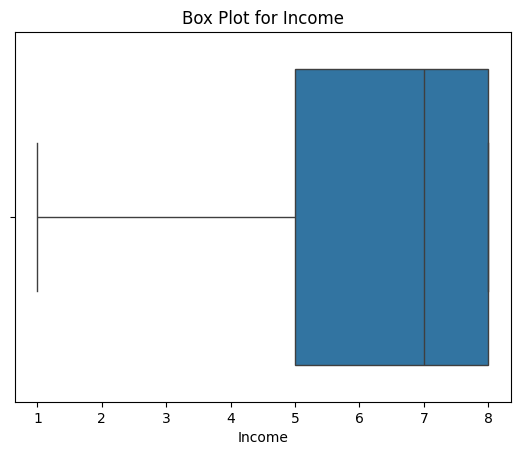

In [13]:
#Outliers for numerical columns
for col in numerical_cols:
    print(f"\nBox plot for: {col}")
    sns.boxplot(x=df_cdc_diabetes[col], orientation='h')  # horizontal boxplot
    plt.title(f"Box Plot for {col}")
    plt.xlabel(col)
    plt.show()

In [14]:
#Form the correlation matrix
corr_matrix = round(df_cdc_diabetes.corr(),2)
corr_matrix

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
HighBP,1.00,0.30,0.10,0.21,0.10,0.13,0.21,-0.13,-0.04,-0.06,...,0.02,0.30,0.06,0.16,0.22,0.05,0.34,-0.14,-0.17,0.26
HighChol,0.30,1.00,0.09,0.11,0.09,0.09,0.18,-0.08,-0.04,-0.04,...,0.01,0.21,0.06,0.12,0.14,0.03,0.27,-0.07,-0.09,0.20
CholCheck,0.10,0.09,1.00,0.03,-0.01,0.02,0.04,0.00,0.02,0.01,...,-0.06,0.05,-0.01,0.03,0.04,-0.02,0.09,0.00,0.01,0.06
BMI,0.21,0.11,0.03,1.00,0.01,0.02,0.05,-0.15,-0.09,-0.06,...,0.06,0.24,0.09,0.12,0.20,0.04,-0.04,-0.10,-0.10,0.22
Smoker,0.10,0.09,-0.01,0.01,1.00,0.06,0.11,-0.09,-0.08,-0.03,...,0.05,0.16,0.09,0.12,0.12,0.09,0.12,-0.16,-0.12,0.06
Stroke,0.13,0.09,0.02,0.02,0.06,1.00,0.20,-0.07,-0.01,-0.04,...,0.03,0.18,0.07,0.15,0.18,0.00,0.13,-0.08,-0.13,0.11
HeartDiseaseorAttack,0.21,0.18,0.04,0.05,0.11,0.20,1.00,-0.09,-0.02,-0.04,...,0.03,0.26,0.06,0.18,0.21,0.09,0.22,-0.10,-0.14,0.18
PhysActivity,-0.13,-0.08,0.00,-0.15,-0.09,-0.07,-0.09,1.00,0.14,0.15,...,-0.06,-0.27,-0.13,-0.22,-0.25,0.03,-0.09,0.20,0.20,-0.12
Fruits,-0.04,-0.04,0.02,-0.09,-0.08,-0.01,-0.02,0.14,1.00,0.25,...,-0.04,-0.10,-0.07,-0.04,-0.05,-0.09,0.06,0.11,0.08,-0.04
Veggies,-0.06,-0.04,0.01,-0.06,-0.03,-0.04,-0.04,0.15,0.25,1.00,...,-0.03,-0.12,-0.06,-0.06,-0.08,-0.06,-0.01,0.15,0.15,-0.06


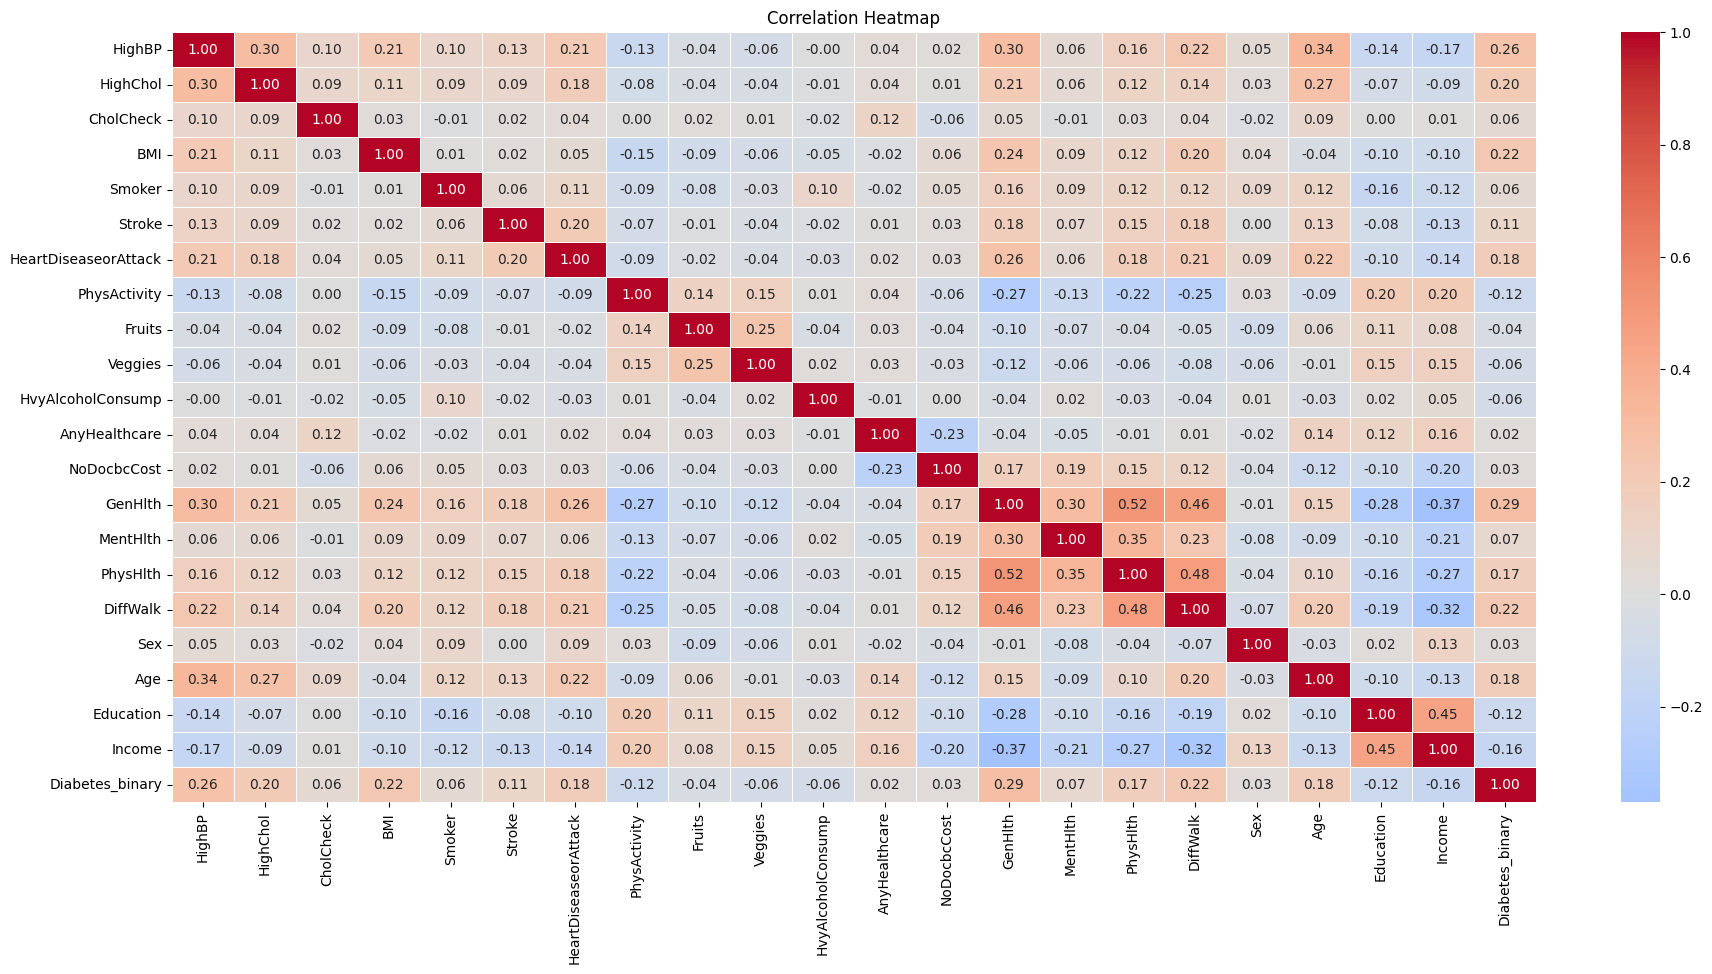

In [15]:
#Visualise correlation as a heatmap
plt.figure(figsize=(22, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, center=0, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [16]:
# Correlation with target variable
target_corr = corr_matrix['Diabetes_binary'].sort_values(ascending=False)
print("\nCorrelation of features with 'Diabetes_binary':")
print(target_corr)


Correlation of features with 'Diabetes_binary':
Diabetes_binary         1.00
GenHlth                 0.29
HighBP                  0.26
DiffWalk                0.22
BMI                     0.22
HighChol                0.20
Age                     0.18
HeartDiseaseorAttack    0.18
PhysHlth                0.17
Stroke                  0.11
MentHlth                0.07
CholCheck               0.06
Smoker                  0.06
NoDocbcCost             0.03
Sex                     0.03
AnyHealthcare           0.02
Fruits                 -0.04
Veggies                -0.06
HvyAlcoholConsump      -0.06
PhysActivity           -0.12
Education              -0.12
Income                 -0.16
Name: Diabetes_binary, dtype: float64


**Data issues handling**
No missing values, no encoding needed, no scaling for binary data

Needed: treating outliers?, feature scaling (standardScaler, MinMaxScaler, RobustScaler) - in pipeline

**Spliting data**

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Logistic regression** - baseline model

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Default Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.98      0.92     43667
           1       0.52      0.16      0.24      7069

    accuracy                           0.86     50736
   macro avg       0.70      0.57      0.58     50736
weighted avg       0.83      0.86      0.83     50736



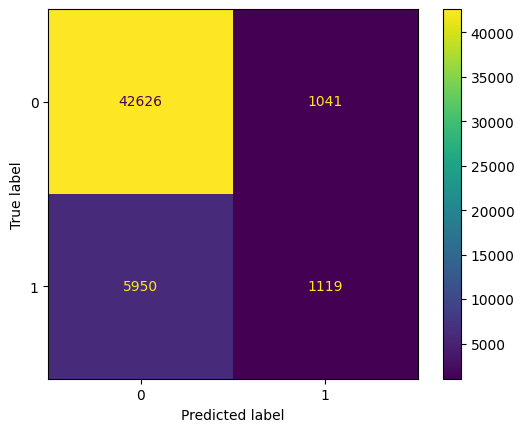

In [18]:
#Default logistic regression
# Build the model
default_lr = LogisticRegression(max_iter=1000, random_state=42)

# Train the model (Fit model)
default_lr.fit(X_train, y_train)

# Test the model (Predict)
y_pred_default = default_lr.predict(X_test)

# Evaluate - Default model evaluation with classifiaction report and confusion matrix
print("Default Logistic Regression")
print(classification_report(y_test, y_pred_default))

cm = confusion_matrix(y_test, y_pred_default)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()


Logistic regression with set hyperparameters (StandardScaler vs RobustdScaler)

Also, time check between PCA and no PCA applictaion

In [19]:
%%time
# Logistic regression with set hyperparameters
# Define pipeline with scaler
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

# Define param grid

param_grid = [
    {
        "model__solver": ["liblinear"],
        "model__penalty": ["l1", "l2"],
        "model__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
        "model__class_weight": ["balanced", None]
    },
    {
        "model__solver": ["saga"],
        "model__penalty": ["elasticnet"],
        "model__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
        "model__class_weight": ["balanced", None],
        "model__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0]  # Only used with elasticnet
    }
]

# Initialize GridSearchCV
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="recall_macro",
    cv=3,
    n_jobs=-1,
    error_score="raise"
)

# Fit GridSearch
grid.fit(X_train, y_train)

# Best model
best_lr = grid.best_estimator_
print("Best Parameters:", grid.best_params_)




/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters: {'model__C': 0.0001, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'liblinear'}
CPU times: user 2.62 s, sys: 513 ms, total: 3.13 s
Wall time: 8min 25s



 Tuned Logistic Regression classification Report
              precision    recall  f1-score   support

           0       0.95      0.70      0.81     43667
           1       0.30      0.79      0.44      7069

    accuracy                           0.71     50736
   macro avg       0.63      0.75      0.62     50736
weighted avg       0.86      0.71      0.76     50736



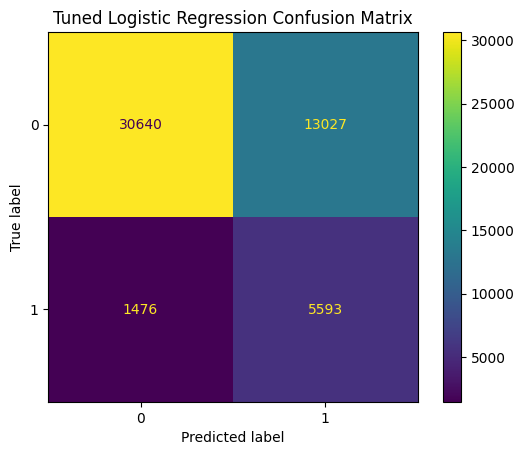

CPU times: user 310 ms, sys: 0 ns, total: 310 ms
Wall time: 192 ms


In [20]:
%%time
# Predict
y_pred_tuned = best_lr.predict(X_test)

# Evaluate
print("\n Tuned Logistic Regression classification Report")
print(classification_report(y_test, y_pred_tuned))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tuned)
plt.title("Tuned Logistic Regression Confusion Matrix")
plt.show()

choose between robust and standard scaler

In [21]:
%%time
#try Robust scaler instead of standardScaler and leave binary features unchanged
#Robust scaler is good for data with outlies and is'nt normal - like this numerical data

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols),
        ('cat', 'passthrough', binary_cols)
    ])
# 1. Define pipeline with scaler
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

# 2. Define param grid

#Param grid defined in two separate dictionaries because:
# - The 'liblinear' solver supports only 'l1' and 'l2' penalties and does NOT support 'elasticnet' or 'l1_ratio'.
# - The 'saga' solver is the only one that supports 'elasticnet' and requires the 'l1_ratio' parameter.
# Separating them ensures only valid combinations of solver and penalty are evaluated by GridSearchCV.

param_grid = [
    {
        "model__solver": ["liblinear"],
        "model__penalty": ["l1", "l2"],
        "model__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
        "model__class_weight": ["balanced", None]
    },
    {
        "model__solver": ["saga"],
        "model__penalty": ["elasticnet"],
        "model__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
        "model__class_weight": ["balanced", None],
        "model__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0]  # Only used with elasticnet
    }
]

# 3. Initialize GridSearchCV
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="recall_macro",
    cv=3,
    n_jobs=-1,
    error_score="raise"
)

# 4. Fit GridSearch
grid.fit(X_train, y_train)

# 5. Best model
best_lr = grid.best_estimator_
print("Best Parameters:", grid.best_params_)




/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters: {'model__C': 0.01, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'liblinear'}
CPU times: user 4.56 s, sys: 749 ms, total: 5.31 s
Wall time: 14min 10s



 Tuned Logistic Regression classification Report
              precision    recall  f1-score   support

           0       0.95      0.73      0.82     43667
           1       0.31      0.76      0.44      7069

    accuracy                           0.73     50736
   macro avg       0.63      0.74      0.63     50736
weighted avg       0.86      0.73      0.77     50736



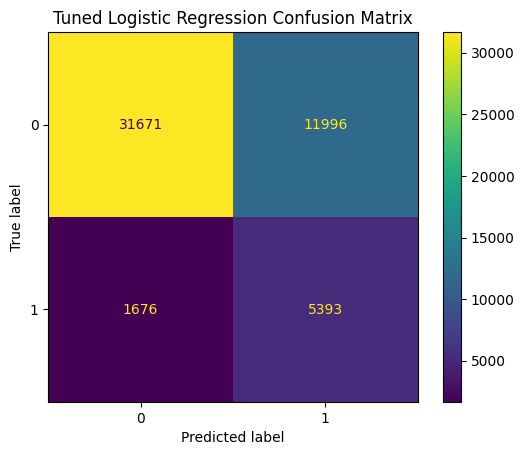

CPU times: user 322 ms, sys: 1.73 ms, total: 324 ms
Wall time: 203 ms


In [22]:
%%time
# 6. Predict
y_pred_tuned = best_lr.predict(X_test)

# 7. Evaluate
print("\n Tuned Logistic Regression classification Report")
print(classification_report(y_test, y_pred_tuned))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tuned)
plt.title("Tuned Logistic Regression Confusion Matrix")
plt.show()

**Feature engenering**

check perfomance of baseline model with all features, selected features(based on feature correlation with target + PCA) - deleting features with low correlation to the target did not improve model performamance. PCA(n_components=0.95) improved model taining time (shorter) but anything below 0.95 reduced prediction (precision, recall and F1-score).

In [23]:
%%time
#Robust scaler with PCA
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols),
        ('cat', 'passthrough', binary_cols)
    ])
# 1. Define pipeline with scaler
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("pca", PCA(n_components=0.95)),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

# 2. Define param grid

#Param grid defined in two separate dictionaries because:
# - The 'liblinear' solver supports only 'l1' and 'l2' penalties and does NOT support 'elasticnet' or 'l1_ratio'.
# - The 'saga' solver is the only one that supports 'elasticnet' and requires the 'l1_ratio' parameter.
# Separating them ensures only valid combinations of solver and penalty are evaluated by GridSearchCV.

param_grid = [
    {
        "model__solver": ["liblinear"],
        "model__penalty": ["l1", "l2"],
        "model__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
        "model__class_weight": ["balanced", None]
    },
    {
        "model__solver": ["saga"],
        "model__penalty": ["elasticnet"],
        "model__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
        "model__class_weight": ["balanced", None],
        "model__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0]  # Only used with elasticnet
    }
]

# 3. Initialize GridSearchCV
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="recall_macro",
    cv=3,
    n_jobs=-1,
    error_score="raise"
)

# 4. Fit GridSearch
grid.fit(X_train, y_train)

# 5. Best model
best_lr = grid.best_estimator_
print("Best Parameters:", grid.best_params_)



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters: {'model__C': 0.001, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'liblinear'}
CPU times: user 2.54 s, sys: 344 ms, total: 2.88 s
Wall time: 4min 43s



 Tuned Logistic Regression classification Report
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     43667
           1       0.31      0.76      0.44      7069

    accuracy                           0.73     50736
   macro avg       0.63      0.74      0.63     50736
weighted avg       0.86      0.73      0.77     50736



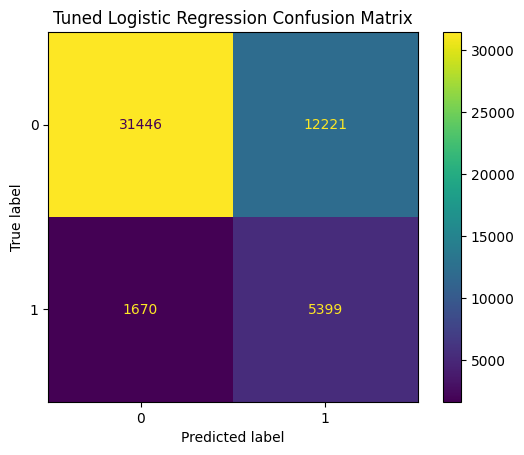

CPU times: user 294 ms, sys: 3.64 ms, total: 297 ms
Wall time: 283 ms


In [24]:
%%time
# 6. Predict
y_pred_tuned = best_lr.predict(X_test)

# 7. Evaluate
print("\n Tuned Logistic Regression classification Report")
print(classification_report(y_test, y_pred_tuned))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tuned)
plt.title("Tuned Logistic Regression Confusion Matrix")
plt.show()

##**Model selection and training**


Training: Logistic Regression


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.94      0.72      0.82     43667
           1       0.30      0.72      0.42      7069

    accuracy                           0.72     50736
   macro avg       0.62      0.72      0.62     50736
weighted avg       0.85      0.72      0.76     50736



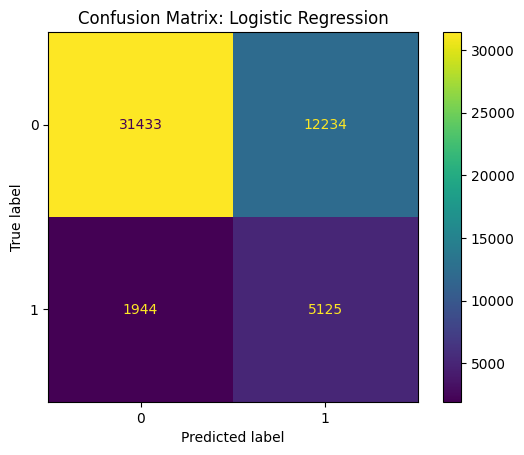


Training: KNN


/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

           0       0.92      0.71      0.80     43667
           1       0.25      0.60      0.35      7069

    accuracy                           0.69     50736
   macro avg       0.58      0.65      0.58     50736
weighted avg       0.82      0.69      0.74     50736



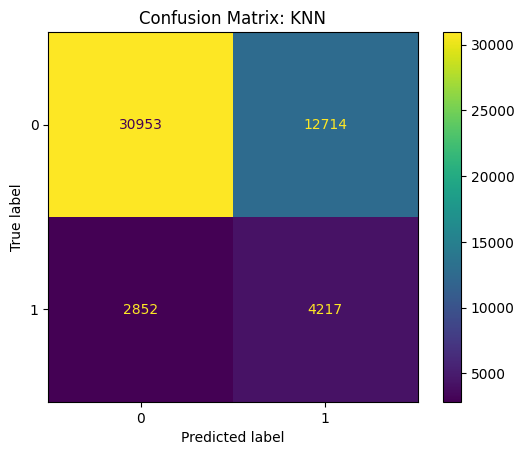


Training: Naive Bayes


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.89      0.81      0.85     43667
           1       0.25      0.38      0.30      7069

    accuracy                           0.75     50736
   macro avg       0.57      0.60      0.58     50736
weighted avg       0.80      0.75      0.77     50736



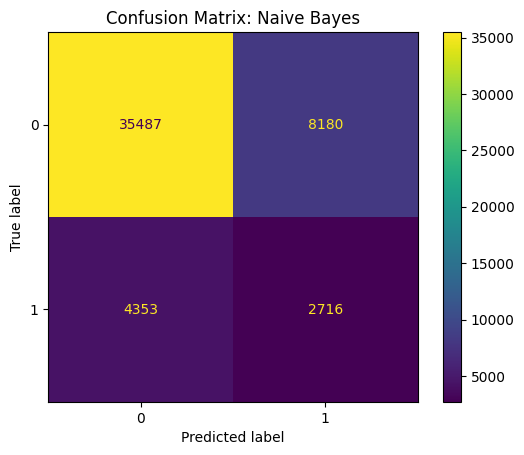


Training: MLP Neural Network


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.94      0.70      0.80     43667
           1       0.28      0.72      0.40      7069

    accuracy                           0.70     50736
   macro avg       0.61      0.71      0.60     50736
weighted avg       0.85      0.70      0.75     50736



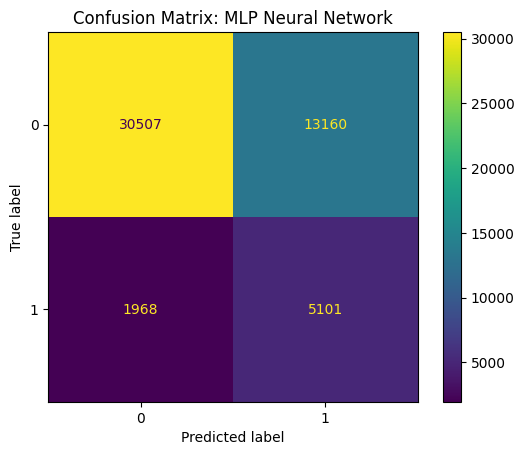


Training: Random Forest


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.95      0.71      0.81     43667
           1       0.29      0.75      0.42      7069

    accuracy                           0.71     50736
   macro avg       0.62      0.73      0.62     50736
weighted avg       0.85      0.71      0.76     50736



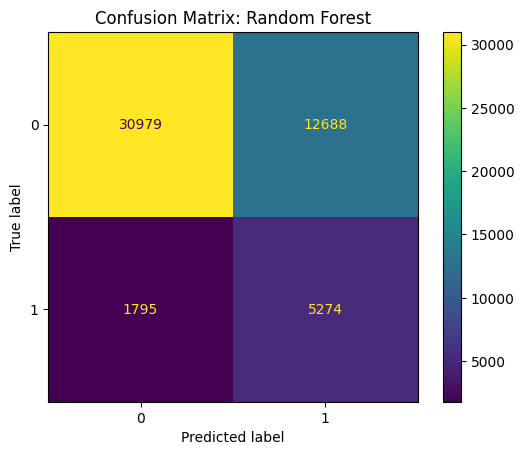


Training: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:44:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.94      0.72      0.82     43667
           1       0.29      0.70      0.41      7069

    accuracy                           0.72     50736
   macro avg       0.61      0.71      0.61     50736
weighted avg       0.85      0.72      0.76     50736



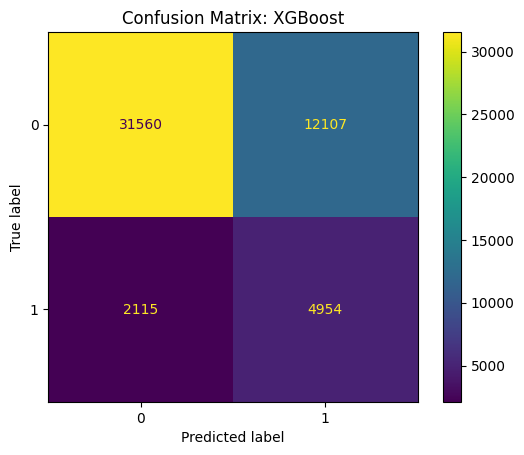

In [25]:
# Define models

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols),
        ('cat', 'passthrough', binary_cols)
    ])

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": MultinomialNB(),
    "MLP Neural Network": MLPClassifier(max_iter=300),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Define pipelines
pipelines = {
    "Logistic Regression": ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("preprocess", preprocessor),
        ("pca", PCA(n_components=0.95)),
        ("model", models["Logistic Regression"])
    ]),
    "KNN": ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("preprocess", preprocessor),
        ("pca", PCA(n_components=0.95)),
        ("model", models["KNN"])
    ]),
    "Naive Bayes": ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("model", models["Naive Bayes"])
    ]),
    "MLP Neural Network": ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("preprocess", preprocessor),
        ("pca", PCA(n_components=0.95)),
        ("model", models["MLP Neural Network"])
    ]),
    "Random Forest": ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("model", models["Random Forest"])
    ]),
    "XGBoost": ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("model", models["XGBoost"])
    ])
}

# Hyperparameter grids
param_grids = {
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10],
        "model__penalty": ["l1", "l2"],
        "model__solver": ["liblinear"]
    },
    "KNN": {
        "model__n_neighbors": [3, 5],
        "model__weights": ["uniform"]
    },
    "Naive Bayes": {},
    "MLP Neural Network": {
        "model__hidden_layer_sizes": [(50, 50)],
        "model__activation": ["relu"],
        "model__alpha": [0.001]
    },
    "Random Forest": {
        "model__n_estimators": [100],
        "model__max_depth": [None, 10],
        "model__class_weight": ["balanced"]
    },
    "XGBoost": {
        "model__n_estimators": [100],
        "model__learning_rate": [0.1],
        "model__scale_pos_weight": [1]
    }
}

# Run evaluation for each model
results = {}

for name, pipeline in pipelines.items():
    print(f"\nTraining: {name}")

    grid = GridSearchCV(pipeline, param_grids.get(name, {}), scoring='recall', cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)

    # Predict probabilities + threshold tuning
    y_proba = grid.predict_proba(X_test)[:, 1]
    threshold = 0.5  # Optional: tune later
    y_pred = (y_proba >= threshold).astype(int)

    # Classification report + confusion matrix
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

    # Save metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {
        "Accuracy": grid.score(X_test, y_test),
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"]
    }



In [26]:
# 6. Display results
results_df = pd.DataFrame(results).T.sort_values(by="F1-score", ascending=False)
print("\n Final Model Performance Table")
print(results_df)


 Final Model Performance Table
                     Accuracy  Precision    Recall  F1-score
Random Forest        0.746074   0.293620  0.746074  0.421397
Logistic Regression  0.724996   0.295236  0.724996  0.419600
XGBoost              0.700806   0.290370  0.700806  0.410609
MLP Neural Network   0.721601   0.279338  0.721601  0.402764
KNN                  0.596548   0.249070  0.596548  0.351417
Naive Bayes          0.384213   0.249266  0.384213  0.302366
